In [1]:
%matplotlib inline
%run 'bin/notebook_utils.py'
%run 'bin/plot_utilization.py'
import matplotlib.ticker as mticker

In [2]:
! radical-stack


  python               : 3.7.7
  pythonpath           : 
  virtualenv           : /Users/mturilli/.virtualenvs/analytics-devel

  radical.analytics    : 0.90.7-v0.72.0-57-gf903ac4@devel
  radical.pilot        : 1.4.0-v1.4.0-48-gafbdfc311@devel
  radical.saga         : 1.4.0
  radical.utils        : 1.4.0



In [3]:
#         'rp.session.login4.mturilli1.018443.0002',
#         'rp.session.login4.mturilli1.018443.0003',

suds = [
        'rp.session.login3.mturilli1.018442.0011',
        'rp.session.login3.mturilli1.018442.0012',
        'rp.session.login4.mturilli1.018444.0000',
        'rp.session.login4.mturilli1.018444.0001',
        'rp.session.login4.mturilli1.018444.0003',
        'rp.session.login4.mturilli1.018444.0004',
        'rp.session.login4.mturilli1.018444.0005'
       ] 
sdir = '../data/raw/'
sids = [sdir+s for s in suds]

In [4]:
%%capture capt

ss = {}
for sid in suds:
    sp = sdir+sid
    ss[sid] = {'s': ra.Session(sp, 'radical.pilot')}
    ss[sid].update({'p': ss[sid]['s'].filter(etype='pilot'   , inplace=False),
                    'u': ss[sid]['s'].filter(etype='unit'    , inplace=False),
                    't': ss[sid]['s'].filter(etype='task'    , inplace=False),
                    'w': ss[sid]['s'].filter(etype='pipeline', inplace=False)})

In [5]:
for sid in suds:
    ss[sid].update({'sid'   : ss[sid]['s'].uid,
                    'pid'   : ss[sid]['p'].list('uid'),
                    'npilot': len(ss[sid]['p'].get()),
                    'lm'    : ss[sid]['s'].get(etype='pilot')[0].cfg['agent_launch_method'],
                    'npact' : len(ss[sid]['p'].timestamps(state='PMGR_ACTIVE')),
                    'nunit' : len(ss[sid]['u'].get()),
                    'nudone': len(ss[sid]['u'].timestamps(state='DONE')),
                    'nufail': len(ss[sid]['u'].timestamps(state='FAILED'))})
    ss[sid].update({'pres'  : ss[sid]['p'].get(uid=ss[sid]['pid'])[0].description['resource'],
                    'ncores': ss[sid]['p'].get(uid=ss[sid]['pid'])[0].description['cores'],
                    'ngpus' : ss[sid]['p'].get(uid=ss[sid]['pid'])[0].description['gpus']})                  
    ss[sid].update({'nnodes': ss[sid]['ngpus']/6})

In [6]:
info = []
for sid in suds:
    info.append({'session'  : sid,
                 'resource' : ss[sid]['pres'],
                 'pilot_lm' : ss[sid]['lm'], 
                 'pilots'   : ss[sid]['npilot'],
                 'ps_active': ss[sid]['npact'],
                 'cores'    : ss[sid]['ncores']/4, 
                 'gpus'     : ss[sid]['ngpus'], 
                 'nodes'    : ss[sid]['nnodes'], 
                 'tasks'    : ss[sid]['nunit'], 
                 'ts_done'  : ss[sid]['nudone'],  
                 'ts_failed': ss[sid]['nufail']})

df_info = pd.DataFrame(info) 
df_info

,session,resource,pilot_lm,pilots,ps_active,cores,gpus,nodes,tasks,ts_done,ts_failed
0,rp.session.login3.mturilli1.018442.0011,ornl.summit,JSRUN,1,1,42.0,6,1.0,11,11,0
1,rp.session.login3.mturilli1.018442.0012,ornl.summit_prte,SSH,1,1,42.0,6,1.0,11,11,0
2,rp.session.login4.mturilli1.018444.0000,ornl.summit_prte,SSH,1,1,84.0,12,2.0,21,21,0
3,rp.session.login4.mturilli1.018444.0001,ornl.summit_prte,SSH,1,1,5376.0,768,128.0,1116,1116,0
4,rp.session.login4.mturilli1.018444.0003,ornl.summit_prte,SSH,1,1,168.0,24,4.0,42,42,0
5,rp.session.login4.mturilli1.018444.0004,ornl.summit_prte,SSH,1,1,168.0,24,4.0,126,126,0
6,rp.session.login4.mturilli1.018444.0005,ornl.summit_prte,SSH,1,1,168.0,24,4.0,126,126,0


In [7]:
UNIT_DURATIONS_DEBUG = {
    'consume' : {
        'u_umngr_create'               : [ {ru.EVENT: 'state'           , ru.STATE: rp.NEW                         },      
                                           {ru.EVENT: 'state'           , ru.STATE: rp.UMGR_SCHEDULING_PENDING     }  ],
        'u_umngr_schedule_queue'       : [ {ru.EVENT: 'state'           , ru.STATE: rp.UMGR_SCHEDULING_PENDING     }, 
                                           {ru.EVENT: 'state'           , ru.STATE: rp.UMGR_SCHEDULING             }  ],
        'u_umngr_schedule'             : [ {ru.EVENT: 'state'           , ru.STATE: rp.UMGR_SCHEDULING             },               
                                           {ru.EVENT: 'state'           , ru.STATE: rp.UMGR_STAGING_INPUT_PENDING  }  ],
        'u_umngr_stage_in_queue'       : [ {ru.EVENT: 'state'           , ru.STATE: rp.UMGR_STAGING_INPUT_PENDING  }, 
                                           {ru.EVENT: 'state'           , ru.STATE: rp.UMGR_STAGING_INPUT          }  ], # push to mongodb
        'u_umngr_stage_in'             : [ {ru.EVENT: 'state'           , ru.STATE: rp.UMGR_STAGING_INPUT          }, 
                                           {ru.EVENT: 'state'           , ru.STATE: rp.AGENT_STAGING_INPUT_PENDING }  ], # wait in mongodb
        'u_agent_stage_in_queue'       : [ {ru.EVENT: 'state'           , ru.STATE: rp.AGENT_STAGING_INPUT_PENDING },  
                                           {ru.EVENT: 'state'           , ru.STATE: rp.AGENT_STAGING_INPUT         }  ], # pull from mongodb 
        'u_agent_stage_in'             : [ {ru.EVENT: 'state'           , ru.STATE: rp.AGENT_STAGING_INPUT         },  
                                           {ru.EVENT: 'state'           , ru.STATE: rp.AGENT_SCHEDULING_PENDING    }  ], 
        'u_agent_schedule_queue'       : [ {ru.EVENT: 'state'           , ru.STATE: rp.AGENT_SCHEDULING_PENDING    },  
                                           {ru.EVENT: 'state'           , ru.STATE: rp.AGENT_SCHEDULING            }  ],
        'u_agent_schedule'             : [ {ru.EVENT: 'state'           , ru.STATE: rp.AGENT_SCHEDULING            },  
                                           {ru.EVENT: 'state'           , ru.STATE: rp.AGENT_EXECUTING_PENDING     }  ], 
        'u_agent_execute_queue'        : [ {ru.EVENT: 'state'           , ru.STATE: rp.AGENT_EXECUTING_PENDING     },  
                                           {ru.EVENT: 'state'           , ru.STATE: rp.AGENT_EXECUTING             }  ], 
        'u_agent_execute_mkdir_start'  : [ {ru.EVENT: 'state'           , ru.STATE: rp.AGENT_EXECUTING             },  
                                           {ru.EVENT: 'exec_mkdir'      , ru.STATE: None                           }  ], 
        'u_agent_execute_mkdir'        : [ {ru.EVENT: 'exec_mkdir'      , ru.STATE: None                           },
                                           {ru.EVENT: 'exec_mkdir_done' , ru.STATE: None                           }  ],
        'u_agent_execute_layer_start'  : [ {ru.EVENT: 'exec_mkdir_done' , ru.STATE: None                           },
                                           {ru.EVENT: 'exec_start'      , ru.STATE: None                           }  ],
        'u_agent_execute_layer'        : [ {ru.EVENT: 'exec_start'      , ru.STATE: None                           },
                                          [{ru.EVENT: 'exec_ok'         , ru.STATE: None                           },
                                           {ru.EVENT: 'exec_fail'       , ru.STATE: None                           } ]], # orte, ssh, mpi, ... 

        'u_agent_cu_start'             : [ {ru.EVENT: 'cu_start'        , ru.STATE: None                           },
                                           {ru.EVENT: 'cu_cd_done'      , ru.STATE: None                           }  ], # PROBLEM: discontinuity
        'u_agent_cu_pre_execute_start' : [ {ru.EVENT: 'cu_cd_done'      , ru.STATE: None                           },
                                           {ru.EVENT: 'cu_pre_start'    , ru.STATE: None                           }  ],
        'u_agent_cu_pre_execute'       : [ {ru.EVENT: 'cu_pre_start'    , ru.STATE: None                           },
                                           {ru.EVENT: 'cu_pre_stop'     , ru.STATE: None                           }  ],
        'u_agent_cu_execute_start'     : [ {ru.EVENT: 'cu_pre_stop'     , ru.STATE: None                           },
                                           {ru.EVENT: 'cu_exec_start'   , ru.STATE: None                           }  ],
        'u_agent_cu_execute'           : [ {ru.EVENT: 'cu_exec_start'   , ru.STATE: None                           },
                                           {ru.EVENT: 'cu_exec_stop'    , ru.STATE: None                           }  ],
        'u_agent_cu_stop'              : [ {ru.EVENT: 'cu_exec_stop'    , ru.STATE: None                           },
                                           {ru.EVENT: 'cu_stop'         , ru.STATE: None                           }  ],

        'u_agent_cu_unschedule_start'  : [ {ru.EVENT: 'exec_stop'       , ru.STATE: None                           },
                                           {ru.EVENT: 'unschedule_start', ru.STATE: None                           }  ], # PROBLEM: discontinuity
        'u_agent_cu_stage_out_start'   : [ {ru.EVENT: 'unschedule_start', ru.STATE: None                           },
                                           {ru.EVENT: 'state'           , ru.STATE: rp.AGENT_STAGING_OUTPUT_PENDING}  ],
        'u_agent_cu_stage_out_queue'   : [ {ru.EVENT: 'state'           , ru.STATE: rp.AGENT_STAGING_OUTPUT_PENDING},
                                           {ru.EVENT: 'state'           , ru.STATE: rp.AGENT_STAGING_OUTPUT        }  ],
        'u_agent_cu_stage_out'         : [ {ru.EVENT: 'state'           , ru.STATE: rp.AGENT_STAGING_OUTPUT        },
                                           {ru.EVENT: 'state'           , ru.STATE: rp.UMGR_STAGING_OUTPUT_PENDING }  ],
        'u_agent_cu_unschedule_stop'   : [ {ru.EVENT: 'state'           , ru.STATE: rp.UMGR_STAGING_OUTPUT_PENDING },
                                         {ru.EVENT: 'unschedule_stop' , ru.STATE: None                           }  ],
        'u_agent_cu_push_to_umngr'     : [ {ru.EVENT: 'unschedule_stop' , ru.STATE: None                           },
                                           {ru.EVENT: 'state'           , ru.STATE: rp.UMGR_STAGING_OUTPUT         }  ], # push/pull mongodb
        'u_umngr_cu_destroy'           : [ {ru.EVENT: 'state'           , ru.STATE: rp.UMGR_STAGING_OUTPUT         },
                                          [{ru.EVENT: 'state'           , ru.STATE: rp.DONE                        },
                                           {ru.EVENT: 'state'           , ru.STATE: rp.CANCELED                    },
                                           {ru.EVENT: 'state'           , ru.STATE: rp.FAILED                      } ]]
    }
}

In [8]:
%%capture capt

u_durations = {}

for sid in suds:
    u_durations[sid] = {}

for sid in suds:
    for uid in ss[sid]['u'].list('uid'):
        unit = ss[sid]['u'].get(etype='unit', uid=uid)[0]
        durations = {}
        for k,v in UNIT_DURATIONS_DEBUG['consume'].items():
            try:
                durations[k] = unit.duration(event=v)
            except:
                print("WARNING: %s: %s: event %s missing" % (sid, uid, v))
                durations[k] = 0
        u_durations[sid].update({uid: durations})

In [9]:
u_durations_df = {}
for sid,durations in u_durations.items():
    u_durations_df[sid] = pd.DataFrame.from_dict(durations, orient='index')

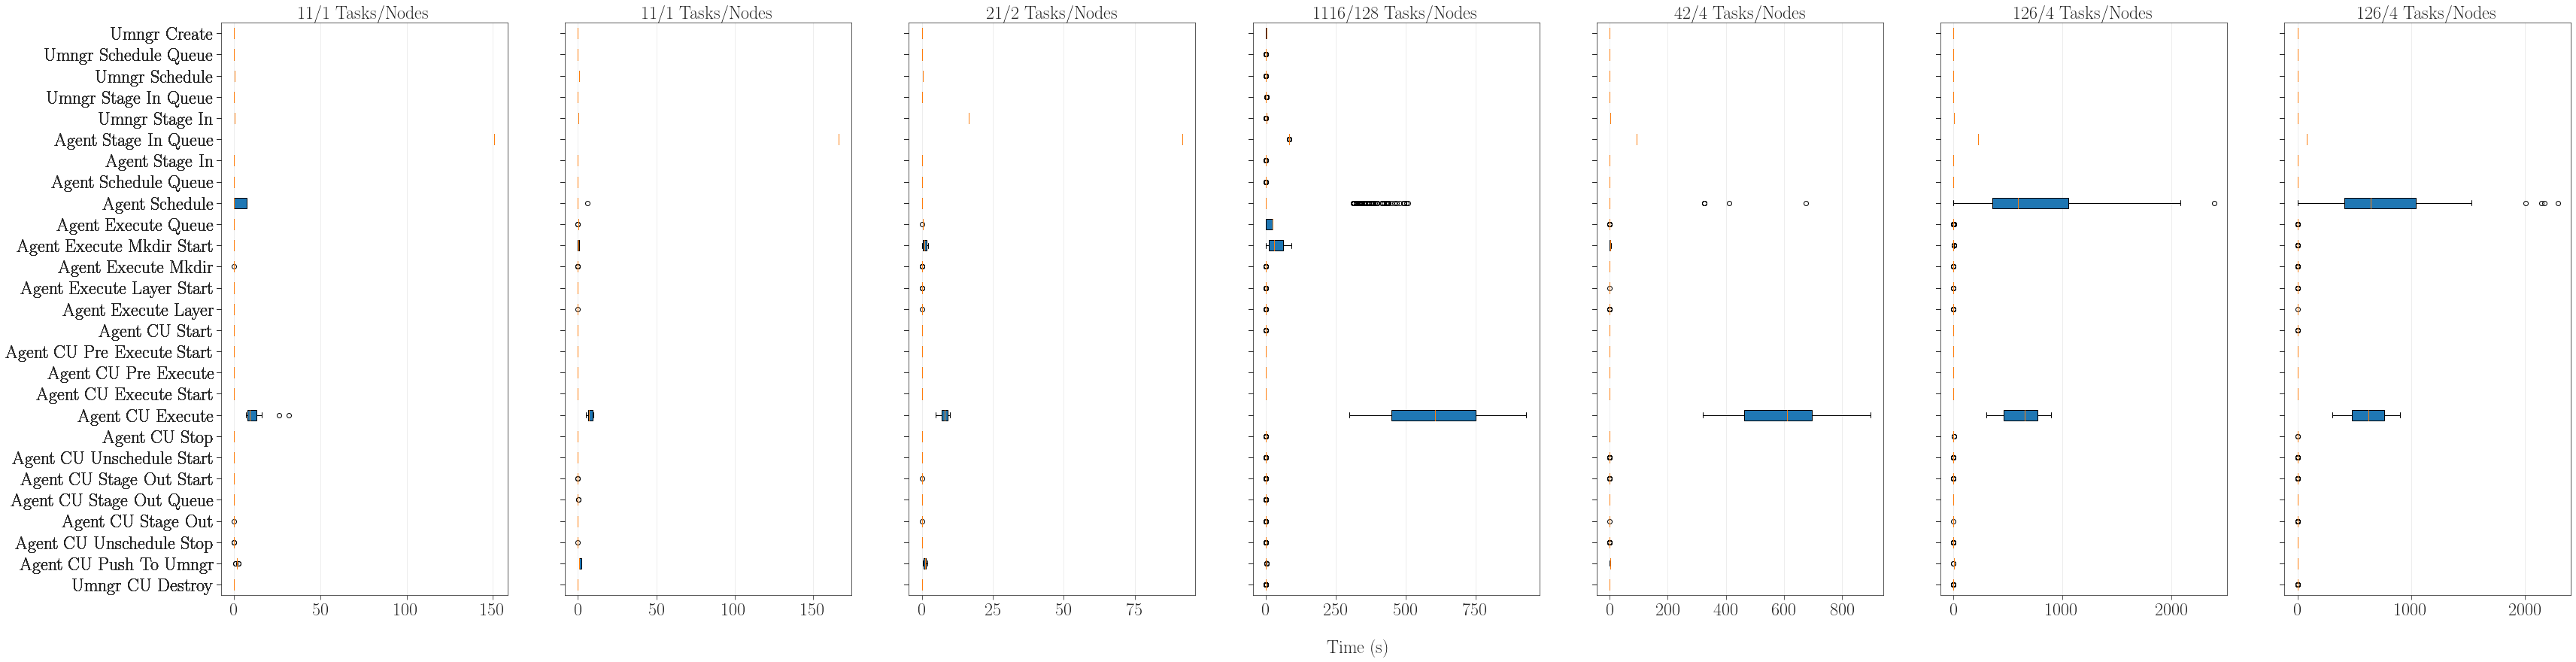

In [10]:
nsessions = len(suds)

fwidth = 8*nsessions
fhight = 14

fig, axarr = plt.subplots(nrows=1, ncols=nsessions, figsize=(fwidth, fhight), sharey=True)

i = 0
j = 'a'
for sid in suds:

    if nsessions > 1:
        ax = axarr[i]
    else:
        ax = axarr

    labels = []
    muted = [] # 'u_agent_schedule', 'u_agent_cu_execute'

    if set(muted).issubset(u_durations_df[sid].columns):
        durations = u_durations_df[sid].drop(muted, axis=1)
    else:
        durations = u_durations_df[sid]

    for label in durations.columns:
        labels.append(label.replace("_", " ").title().replace("U ", "").replace("Cu", "CU"))
    labels = list(reversed(labels))

    boxes = []
    for duration in list(reversed(durations.columns)):
        boxes.append(durations[duration].values)
        
    ax.title.set_text('%s/%s Tasks/Nodes' % (ss[sid]['nunit'], int(ss[sid]['nnodes'])))

    ax.boxplot(boxes, patch_artist=True, labels=labels, vert=False),

    ax.xaxis.grid(True, linestyle='-', which='major', color='lightgrey', alpha=0.5)
    ax.set_axisbelow(True)
    
    i = i+1
    j = chr(ord(j) + 1)

fig.text( 0.5 , 0.05, 'Time (s)', ha='center', fontsize=24)

plt.savefig('figures/baseline_json_prrte.pdf', dpi=300, bbox_inches='tight')
plt.savefig('figures/baseline_json_prrte.png', dpi=300, bbox_inches='tight')

In [11]:
metrics_default = [

        # pilot overheads (global)
        ['Pilot Startup',     ['boot', 'setup_1']],
        ['Pilot Termination', ['term' ]],

        # derived pilot durations
        ['Agent Nodes',       ['agent']],
        ['Warmup',            ['warm' ]],
        ['Draining',          ['drain']],
        ['Idle',              ['idle' ]],

        # unit durations (PRTE)
        ['Prepare Exec',      ['exec_queue', 'exec_prep']],
        ['Exec RP',           ['exec_rp', 'exec_sh', 'term_sh', 'term_rp']],
        ['Exec Cmd',          ['exec_cmd']],
        ['Unschedule',        ['unschedule']],
]

In [12]:
%%capture capt

# Remove cache
! rm -r ~/.radical/analytics

# get utilization information
# FIXME: remove bogus session
# suds = ['rp.session.login4.mturilli1.018443.0002']
# sids = [sdir+s for s in suds]

sobjs = ra.Experiment(sids, stype='radical.pilot')
provided, consumed, stats_abs, stats_rel, info = sobjs.utilization(metrics=metrics_default)

In [13]:
# x-axis labels
xkeys = list()

# get the numbers we actually want to plot
for session in sobjs.sessions:

    n_units = len(session.get(etype='unit'))
    
    p_size = 0
    for pilot in session.get(etype='pilot'):
        p_size += pilot.description['cores']

    xkeys.append('%s / %s' % (n_units, p_size))

In [14]:
def update_ticks(x, pos):
    return int(x/168)
#     return int(x)

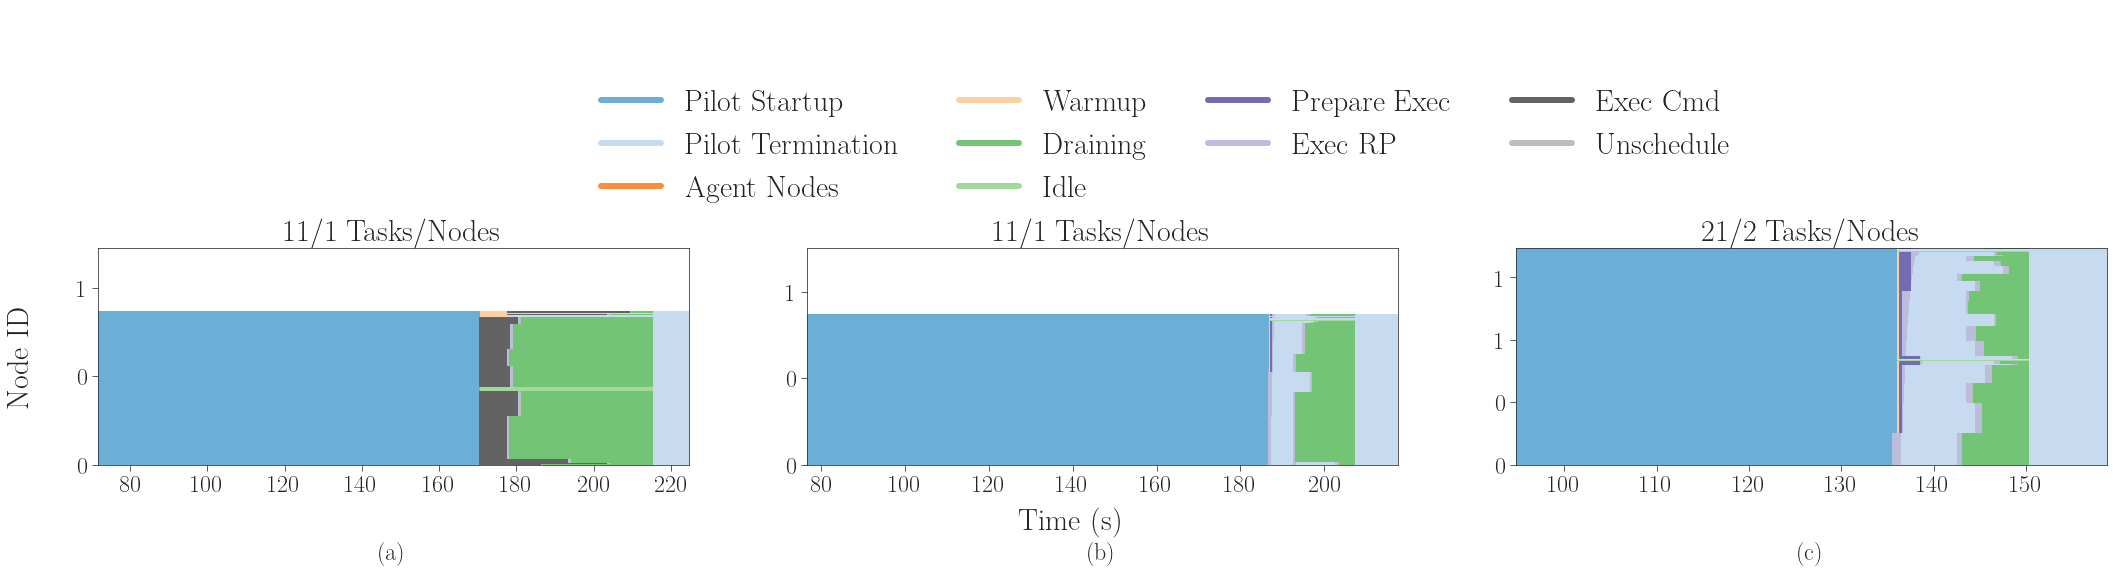

In [15]:
skip = ['rp.session.login4.mturilli1.018444.0001',
        'rp.session.login4.mturilli1.018444.0003',
        'rp.session.login4.mturilli1.018444.0004',
        'rp.session.login4.mturilli1.018444.0005']
nsids = len(suds) - len(skip)

fwidth = 36
fhight = 4
fig, axarr = plt.subplots(1, nsids, figsize=(fwidth, fhight))

i = 0
j = 'a'
for sid in suds:
    
    if sid in skip:
        continue

    ax = axarr[i]
    cmap = mpl.cm.get_cmap('tab20c')

    step = 1.0 / (len(metrics_default) + 1)
    this = step / 1.0
    legend = list()

    x_min = None
    x_max = None
    y_min = None
    y_max = None
    
    ax.set_title('%s/%s Tasks/Nodes' % (ss[sid]['nunit'], int(ss[sid]['nnodes'])), fontdict={'fontsize': 30})

    for metric in metrics_default:

        color = cmap(this)
        this += step

        legend.append(mpl.lines.Line2D([0], [0], color=color, lw=6))

        if isinstance(metric, list):
            name = metric[0]
            parts = metric[1]
        else:
            name = metric
            parts = [metric]

        for part in parts:
            for uid in consumed[sid][part]:
                for block in consumed[sid][part][uid]:
                    orig_x = block[0]
                    orig_y = block[2] - 0.5
                    width = block[1] - block[0]
                    height = block[3] - block[2] + 1.0

                    if x_min is None:
                        x_min = orig_x
                    if x_max is None:
                        x_max = orig_x + width
                    if y_min is None:
                        y_min = orig_x
                    if y_max is None:
                        y_max = orig_x + height

                    x_min = min(x_min, orig_x)
                    y_min = min(y_min, orig_y)
                    x_max = max(x_max, orig_x + width)
                    y_max = max(y_max, orig_y + height)

                    patch = mpl.patches.Rectangle((orig_x, orig_y),
                                                  width, height,
                                                  facecolor=color,
                                                  edgecolor='black',
                                                  fill=True, lw=0.0)
                    ax.add_patch(patch)

    ax.set_xlim([x_min, x_max])
    ax.set_ylim([y_min, y_max])
    
    ax.set_xlabel('(%s)' % j, labelpad=45)
    ax.yaxis.set_major_formatter(mticker.FuncFormatter(update_ticks))

    i = i+1
    j = chr(ord(j) + 1)

# Add common axes lables
fig.text(0.09,  0.5, 'Node ID' , va='center', rotation='vertical', fontsize=30)
fig.text(0.5 , -0.1, 'Time (s)', ha='center', fontsize=30)
    
# Add legend
fig.legend(legend, [m[0] for m in metrics_default], loc='upper center', 
           bbox_to_anchor=(0.45, 1.77), fontsize=30, ncol=4)

plt.savefig('figures/ru_summit_prrte_tests.pdf', dpi=300, bbox_inches='tight')
plt.savefig('figures/ru_summit_prrte_tests.png', dpi=300, bbox_inches='tight')

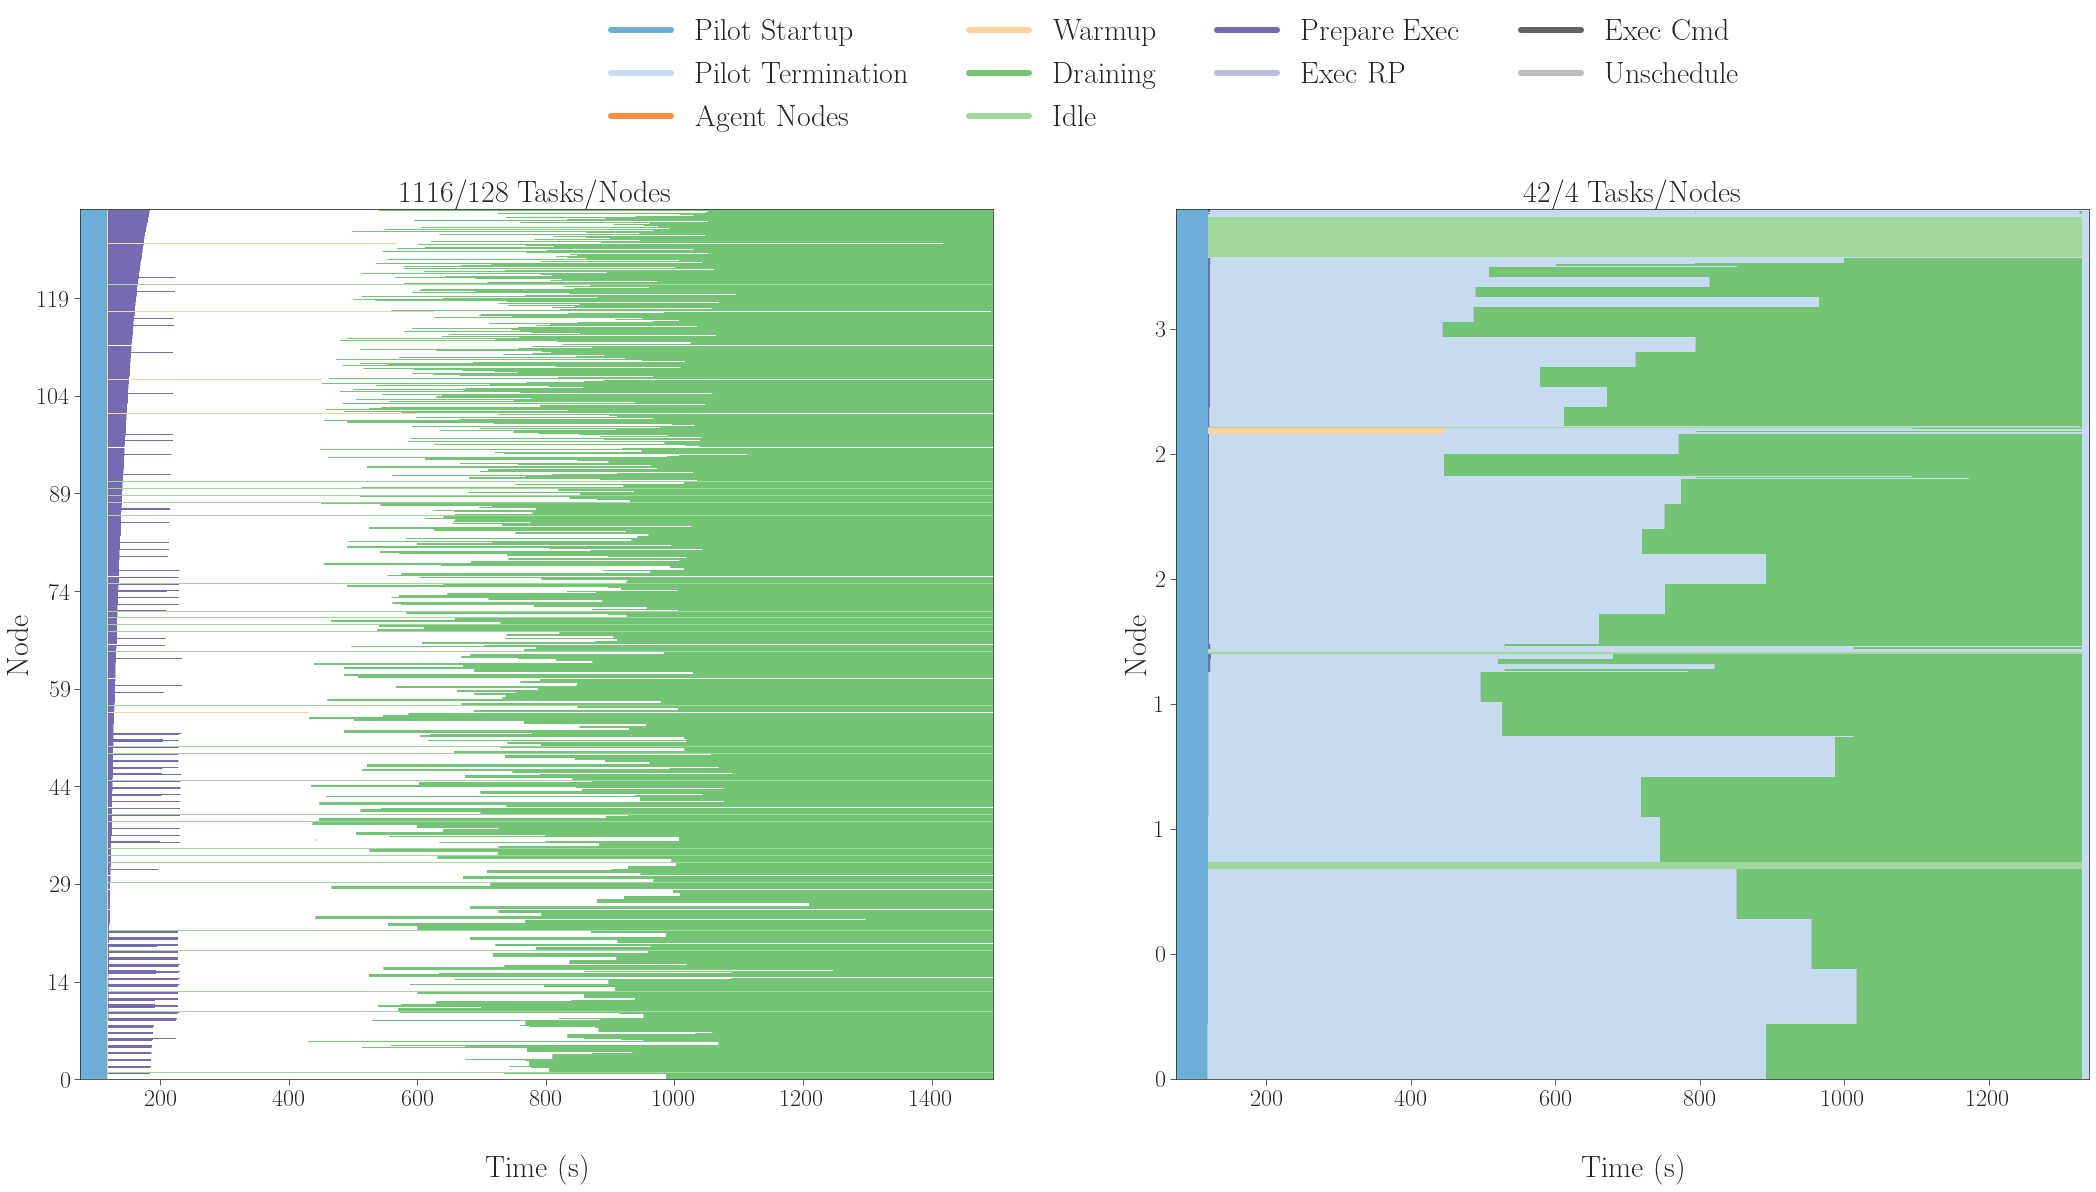

In [16]:
skip = ['rp.session.login3.mturilli1.018442.0011',
        'rp.session.login3.mturilli1.018442.0012',
        'rp.session.login4.mturilli1.018444.0000',
        'rp.session.login4.mturilli1.018444.0004',
        'rp.session.login4.mturilli1.018444.0005']
nsids = len(suds) - len(skip)

fwidth = 36
fhight = 16
fig, axarr = plt.subplots(1, nsids, sharex='col', figsize=(fwidth, fhight))

i = 0
j = 'a'
for sid in suds:
    
    if sid in skip:
        continue

    if nsids > 1:
        ax = axarr[i]
        ax.set_xlabel('(%s)' % j, labelpad=45)
    else:
        ax = axarr

    cmap = mpl.cm.get_cmap('tab20c')

    step = 1.0 / (len(metrics_default) + 1)
    this = step / 1.0
    legend = list()

    x_min = None
    x_max = None
    y_min = None
    y_max = None
    
    ax.set_title('%s/%s Tasks/Nodes' % (ss[sid]['nunit'], int(ss[sid]['nnodes'])), fontdict={'fontsize': 30})

    for metric in metrics_default:

        color = cmap(this)
        this += step

        legend.append(mpl.lines.Line2D([0], [0], color=color, lw=6))

        if isinstance(metric, list):
            name = metric[0]
            parts = metric[1]
        else:
            name = metric
            parts = [metric]

        for part in parts:
            for uid in consumed[sid][part]:
                for block in consumed[sid][part][uid]:
                    orig_x = block[0]
                    orig_y = block[2] - 0.5
                    width = block[1] - block[0]
                    height = block[3] - block[2] + 1.0

                    if x_min is None:
                        x_min = orig_x
                    if x_max is None:
                        x_max = orig_x + width
                    if y_min is None:
                        y_min = orig_x
                    if y_max is None:
                        y_max = orig_x + height

                    x_min = min(x_min, orig_x)
                    y_min = min(y_min, orig_y)
                    x_max = max(x_max, orig_x + width)
                    y_max = max(y_max, orig_y + height)

                    patch = mpl.patches.Rectangle((orig_x, orig_y),
                                                  width, height,
                                                  facecolor=color,
                                                  edgecolor='black',
                                                  fill=True, lw=0.0)
                    ax.add_patch(patch)

    ax.set_xlim([x_min, x_max])
    ax.set_ylim([y_min, y_max])
    
    ax.set_xlabel('Time (s)', fontsize=30)
    ax.set_ylabel('Node', fontsize=30)
    
    ax.yaxis.set_major_formatter(mticker.FuncFormatter(update_ticks))

    i = i+1
    j = chr(ord(j) + 1)
    
# Add legend
ax.legend(legend, [m[0] for m in metrics_default], loc='upper center',
           bbox_to_anchor=(0, 1.25), fontsize=30, ncol=4)

plt.savefig('figures/ru_summit_prrte_single_gen.pdf', dpi=300, bbox_inches='tight')
plt.savefig('figures/ru_summit_prrte_single_gen.png', dpi=300, bbox_inches='tight')

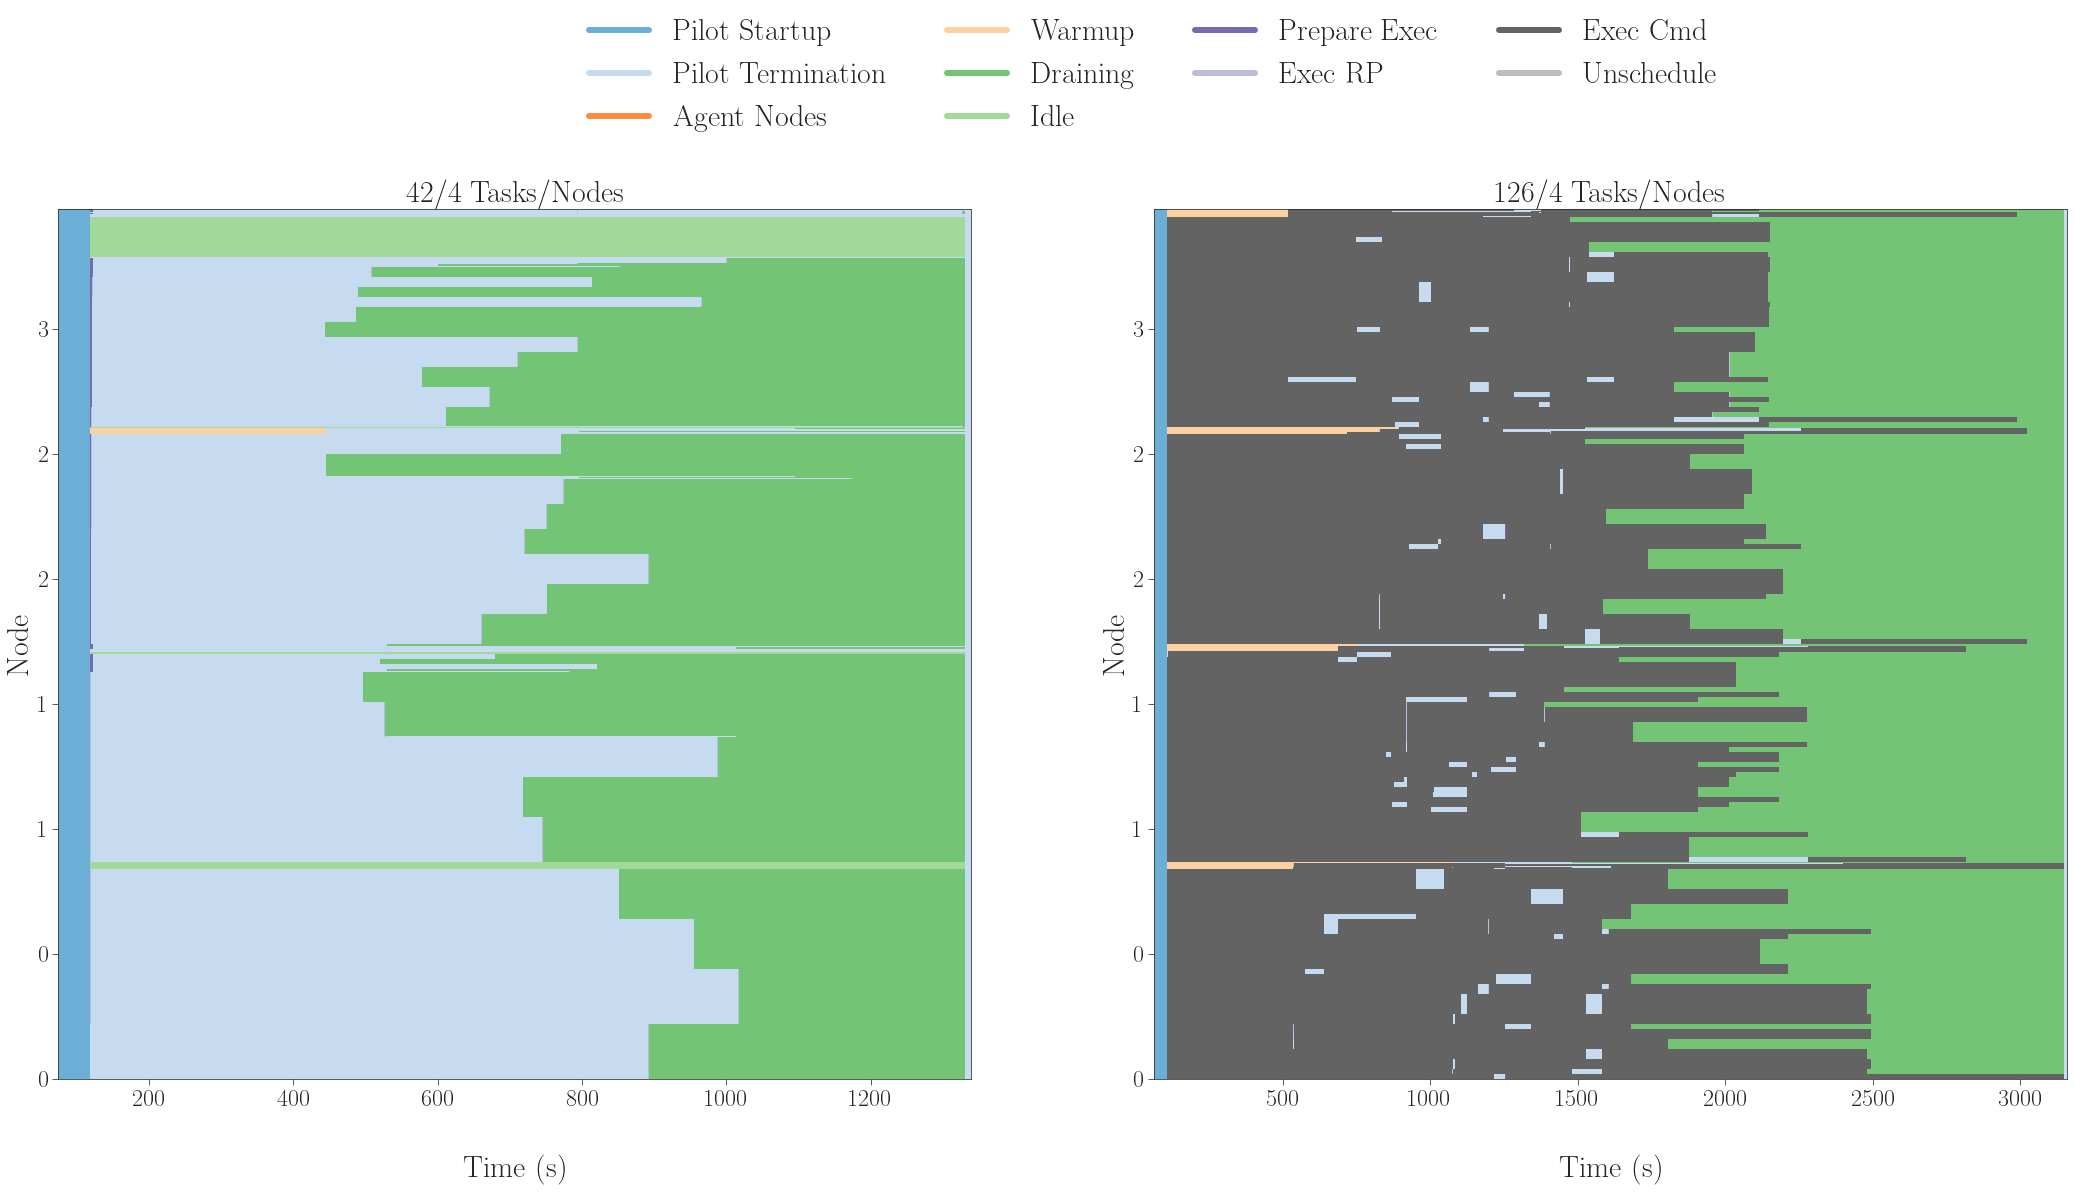

In [17]:
skip = ['rp.session.login3.mturilli1.018442.0011',
        'rp.session.login3.mturilli1.018442.0012',
        'rp.session.login4.mturilli1.018444.0000',
        'rp.session.login4.mturilli1.018444.0001',
        'rp.session.login4.mturilli1.018444.0004']
nsids = len(suds) - len(skip)

fwidth = 36
fhight = 16
fig, axarr = plt.subplots(1, nsids, sharex='col', figsize=(fwidth, fhight))

i = 0
j = 'a'
for sid in suds:
    
    if sid in skip:
        continue

    if nsids > 1:
        ax = axarr[i]
        ax.set_xlabel('(%s)' % j, labelpad=45)
    else:
        ax = axarr

    cmap = mpl.cm.get_cmap('tab20c')

    step = 1.0 / (len(metrics_default) + 1)
    this = step / 1.0
    legend = list()

    x_min = None
    x_max = None
    y_min = None
    y_max = None
    
    ax.set_title('%s/%s Tasks/Nodes' % (ss[sid]['nunit'], int(ss[sid]['nnodes'])), fontdict={'fontsize': 30})

    for metric in metrics_default:

        color = cmap(this)
        this += step

        legend.append(mpl.lines.Line2D([0], [0], color=color, lw=6))

        if isinstance(metric, list):
            name = metric[0]
            parts = metric[1]
        else:
            name = metric
            parts = [metric]

        for part in parts:
            for uid in consumed[sid][part]:
                for block in consumed[sid][part][uid]:
                    orig_x = block[0]
                    orig_y = block[2] - 0.5
                    width = block[1] - block[0]
                    height = block[3] - block[2] + 1.0

                    if x_min is None:
                        x_min = orig_x
                    if x_max is None:
                        x_max = orig_x + width
                    if y_min is None:
                        y_min = orig_x
                    if y_max is None:
                        y_max = orig_x + height

                    x_min = min(x_min, orig_x)
                    y_min = min(y_min, orig_y)
                    x_max = max(x_max, orig_x + width)
                    y_max = max(y_max, orig_y + height)

                    patch = mpl.patches.Rectangle((orig_x, orig_y),
                                                  width, height,
                                                  facecolor=color,
                                                  edgecolor='black',
                                                  fill=True, lw=0.0)
                    ax.add_patch(patch)

    ax.set_xlim([x_min, x_max])
    ax.set_ylim([y_min, y_max])
    
    ax.set_xlabel('Time (s)', fontsize=30)
    ax.set_ylabel('Node', fontsize=30)
    
    ax.yaxis.set_major_formatter(mticker.FuncFormatter(update_ticks))

    i = i+1
    j = chr(ord(j) + 1)
    
# Add legend
ax.legend(legend, [m[0] for m in metrics_default], loc='upper center',
           bbox_to_anchor=(0, 1.25), fontsize=30, ncol=4)

plt.savefig('figures/ru_summit_prrte_multi_gen.pdf', dpi=300, bbox_inches='tight')
plt.savefig('figures/ru_summit_prrte_multi_gen.png', dpi=300, bbox_inches='tight')